# MNIST Model Follow Along (12-17-2022)

Goal: Learn more about the later bits of Fast.ai book, Chapter 4. 

I've become decent at getting a rough SGD setup going, but the later parts of the chapter get into the fundamental building blocks of more complicated models, and I want to be able to grok those and repro those from scratch.

After going through the code again like this, I'll try one more time to repro everything from scratch.

### Getting the Data Loaded...

In [1]:
from fastai.data.external import untar_data, URLs

path = untar_data(URLs.MNIST_SAMPLE)

In [3]:
from pathlib import Path

Path.BASE_PATH = path
path.ls()

(#3) [Path('labels.csv'),Path('valid'),Path('train')]

In [4]:
threes = (path/'train'/'3').ls().sorted()
sevens = (path/'train'/'7').ls().sorted()
threes

(#6131) [Path('train/3/10.png'),Path('train/3/10000.png'),Path('train/3/10011.png'),Path('train/3/10031.png'),Path('train/3/10034.png'),Path('train/3/10042.png'),Path('train/3/10052.png'),Path('train/3/1007.png'),Path('train/3/10074.png'),Path('train/3/10091.png')...]

In [6]:
from PIL import Image

im3_path = threes[1]
im3 = Image.open(im3_path)
im3

In [9]:
import torch

In [14]:
from numpy import array

array(im3)[9:10]

array([[  0,   0,   0,   0,   0,   3,  20,  20,  15,   0,   0,   0,   0,
          0,  43, 224, 253, 245,  74,   0,   0,   0,   0,   0,   0,   0,
          0,   0]], dtype=uint8)

In [15]:
im3_t = torch.as_tensor(array(im3))
im3_t.shape

torch.Size([28, 28])

In [16]:
three_tensors = [torch.as_tensor(array(Image.open(im_path))) for im_path in threes]
seven_tensors = [torch.as_tensor(array(Image.open(im_path))) for im_path in sevens]
len(three_tensors), len(seven_tensors)

(6131, 6265)

In [17]:
stacked_threes = torch.stack(three_tensors).float()/255
stacked_sevens = torch.stack(seven_tensors).float()/255
stacked_threes.shape, stacked_sevens.shape

(torch.Size([6131, 28, 28]), torch.Size([6265, 28, 28]))

In [18]:
valid_3_tens = torch.stack([torch.as_tensor(array(Image.open(im_path))) for im_path in (path/'valid'/'3').ls().sorted()]).float()/255
valid_7_tens = torch.stack([torch.as_tensor(array(Image.open(im_path))) for im_path in (path/'valid'/'7').ls().sorted()]).float()/255
valid_3_tens.shape, valid_7_tens.shape

(torch.Size([1010, 28, 28]), torch.Size([1028, 28, 28]))

In [19]:
train_x = torch.cat([stacked_threes, stacked_sevens]).view(-1, 28*28)
train_x.shape

torch.Size([12396, 784])

In [21]:
train_y = torch.as_tensor([1]*len(threes) + [0]*len(sevens)).unsqueeze(1)
train_y.shape

torch.Size([12396, 1])

In [22]:
dset = list(zip(train_x, train_y))
x, y = dset[0]
x.shape, y

(torch.Size([784]), tensor([1]))

In [26]:
valid_x = torch.cat([valid_3_tens, valid_7_tens]).view(-1, 28*28)
valid_y = torch.as_tensor([1]*len(valid_3_tens) + [0]*len(valid_7_tens)).unsqueeze(1)
valid_dset = list(zip(valid_x, valid_y))
valid_x.shape, valid_y.shape, len(valid_dset), valid_dset[0][0].shape, valid_dset[0][1]

(torch.Size([2038, 784]),
 torch.Size([2038, 1]),
 2038,
 torch.Size([784]),
 tensor([1]))

### Okay, this is about where I comfortably get to solo (without reference).

In [27]:
def init_params(size, std=1.0): return (torch.randn(size)*std).requires_grad_()

In [28]:
# I'm noticing that the shape of the weights is _slightly_ different than what I was doing. I was just doing a straight array
# and then making that into a tensor. I didn't realize that the torch.randn function was thing...neat!

weights = init_params((28*28, 1))

In [29]:
bias = init_params(1)

In [30]:
(train_x[0]*weights.T).sum() + bias

tensor([6.6882], grad_fn=<AddBackward0>)

In [31]:
def linear1(xb): return xb@weights + bias
preds = linear1(train_x)
preds

tensor([[ 6.6882],
        [ 7.1473],
        [-9.1151],
        ...,
        [-3.7317],
        [-5.8599],
        [-3.6317]], grad_fn=<AddBackward0>)

Just testing whether my previous method of weight init amounts to the same thing as the method above...

In [33]:
weights_test = torch.as_tensor(np.random.randn(28*28))
weights_test.shape, weights.shape, weights_test[0], weights[0]

(torch.Size([784]),
 torch.Size([784, 1]),
 tensor(0.3140, dtype=torch.float64),
 tensor([-2.4186], grad_fn=<SelectBackward0>))

Nope! It doesn't. They would amount to the same thing if I called unsqueeze here. 

Hmm, I'm a little confused about how much this difference matters though.

Let's see...

In [34]:
weights_exp_squeezed = init_params(3*3)
weights_exp_unsqueezed = init_params((3*3, 1))
weights_exp_squeezed.shape, weights_exp_unsqueezed.shape

(torch.Size([9]), torch.Size([9, 1]))

In [38]:
data_exp = torch.randn(9)
data_exp.shape

torch.Size([9])

In [40]:
res_1 = data_exp@weights_exp_squeezed
res_2 = data_exp@weights_exp_unsqueezed
res_1.shape, res_2.shape, res_1, res_2

(torch.Size([]),
 torch.Size([1]),
 tensor(-1.4323, grad_fn=<DotBackward0>),
 tensor([6.5964], grad_fn=<SqueezeBackward3>))

So, they amount to the same thing, just a different rank of the resulting tensor. Either way, we just end up with a single number. Hmmm... I don't know. Maybe this comes into play with the next steps?...

In [41]:
corrects = (preds>0.0).float() == train_y
corrects

tensor([[ True],
        [ True],
        [False],
        ...,
        [ True],
        [ True],
        [ True]])

In [42]:
corrects.float().mean().item()

0.700709879398346

Note: In my previous experiments, I wasn't making any metrics

In [43]:
with torch.no_grad(): weights[0] *= 1.0001

In [44]:
preds = linear1(train_x)
corrects_2 = ((preds>0.0).float() == train_y).float().mean()
corrects_2, corrects_2.item()

(tensor(0.7007), 0.700709879398346)

In [46]:
def mnist_loss(preds, targets):
    preds = preds.sigmoid()
    return torch.where(targets==1, 1-preds, preds).mean()

In [50]:
from fastai.data.load import DataLoader,first

dl = DataLoader(dset, batch_size=256)
xb, yb = first(dl)
xb.shape, yb.shape

(torch.Size([256, 784]), torch.Size([256, 1]))

In [51]:
valid_dl = DataLoader(valid_dset, batch_size=256)

In [52]:
batch = train_x[:4]
batch.shape

torch.Size([4, 784])

In [53]:
preds = linear1(batch)
preds

tensor([[ 6.6882],
        [ 7.1473],
        [-9.1151],
        [-4.5785]], grad_fn=<AddBackward0>)

In [54]:
loss = mnist_loss(preds, train_y[:4])
loss

tensor(0.4979, grad_fn=<MeanBackward0>)

In [55]:
loss.backward()
weights.grad.shape, weights.grad.mean(), bias.grad

(torch.Size([784, 1]), tensor(-0.0005), tensor([-0.0031]))

In [56]:
def calc_grad(xb, yb, model):
    preds = model(xb)
    loss = mnist_loss(preds, yb)
    loss.backward()

In [61]:
# This works to zero the grad, but the notebook was doing `weights.grad.zero_()`.
# That doesn't work for me, and I've seen a few different ways of doing it. 
# Will look more into that at some point.

weights.grad = None
bias.grad = None

In [63]:
def train_epoch(model, lr, params):
    for xb, yb in dl:
        calc_grad(xb, yb, linear1)
        for param in params:
            param.data -= param.grad * lr
            param.grad = None

In [64]:
(preds>0.0).float() == train_y[:4]

tensor([[ True],
        [ True],
        [False],
        [False]])

In [65]:
def batch_accuracy(xb, yb):
    preds = xb.sigmoid()
    correct = (preds>0.5) == yb
    return correct.float().mean()

In [66]:
batch_accuracy(linear1(batch), train_y[:4])

tensor(0.5000)

In [67]:
def validate_epoch(model):
    accs = [batch_accuracy(model(xb), yb) for xb,yb in valid_dl]
    return round(torch.stack(accs).mean().item(), 4)

In [68]:
validate_epoch(linear1)

0.6923

In [69]:
lr = 1.
params = weights,bias
train_epoch(linear1, lr, params)
validate_epoch(linear1)

0.769

In [70]:
for i in range(20):
    train_epoch(linear1, lr, params)
    print(validate_epoch(linear1), end=' ')

0.8935 0.9296 0.9394 0.9511 0.9531 0.956 0.9575 0.9609 0.9633 0.9629 0.9638 0.9638 0.9648 0.9663 0.9673 0.9682 0.9687 0.9692 0.9697 0.9697 

### Creating An Optimizer

In [72]:
from torch import nn

linear_model = nn.Linear(28*28, 1)

In [73]:
w,b = linear_model.parameters()
w.shape, b.shape

(torch.Size([1, 784]), torch.Size([1]))

Okay, so we make an optimizer below. An optimizer appears to be just a wrapper class around adjusting the gradients. In other words, it does the "optimizing", stepping us closer to a set of parameters that does the job we want.

What's sort of counter-intuitive to me is that, I would think that an optimizer would also find the gradients, or find the direction to optimize, but of course that's done under the hood with PyTorch.

In [75]:
class BasicOptim:
    def __init__(self, params, lr): self.params, self.lr = list(params), lr
    
    def step(self, *args, **kwargs):
        for p in self.params: p.data -= p.grad.data * self.lr
        
    def zero_grad(self, *args, **kwargs):
        for p in self.params: p.grad = None

In [76]:
# We're passing the new model's parameters here. It seems like our class is just holding a reference to the parameters here.
# I'd like to look more into how pass-by-reference works in Python...

opt = BasicOptim(linear_model.parameters(), lr)

In [77]:
def train_epoch(model):
    for xb, yb in dl:
        calc_grad(xb, yb, model)
        opt.step()
        opt.zero_grad()

In [78]:
validate_epoch(linear_model)

0.5063

In [79]:
def train_model(model, epochs):
    for i in range(epochs):
        train_epoch(model)
        print(validate_epoch(model), end=' ')

In [80]:
train_model(linear_model, 20)

0.4932 0.6782 0.8682 0.9185 0.9355 0.9502 0.9565 0.9634 0.9663 0.9692 0.9702 0.9712 0.9736 0.9751 0.9756 0.977 0.9775 0.978 0.978 0.979 

Okay, so here we swap out our hand-written optimizer with Pytorch's. Seems simple enough.

The current building blocks:
- optimizer (Pytorch)
- model (linear, Pytorch)
- dataloader (fast.ai)

In [96]:
# The book uses the fastai SGD class, not the torch one. Wrapper, perhaps?

# from torch.optim import SGD
from fastai.optimizer import SGD

linear_model = nn.Linear(28*28, 1)
opt = SGD(linear_model.parameters(), lr)
train_model(linear_model, 20)

0.4932 0.8555 0.8242 0.9097 0.9307 0.9468 0.9546 0.9619 0.9658 0.9678 0.9697 0.9721 0.9731 0.9751 0.9756 0.977 0.9775 0.9775 0.9785 0.9785 

In [89]:
# I'm not sure why Dataloaders is in vision.data.
from fastai.vision.data import DataLoaders

dls = DataLoaders(dl, valid_dl)

In [102]:
# This import took a bit to find. Remember: if you're doing a vision task, the import is likely in the vision package.
# ...but the Learner doesn't seem specific to visual learning tasks. I don't yet get the API organization.
from fastai.vision.all import Learner

learn = Learner(dls, nn.Linear(28*28, 1), opt_func=SGD,
                loss_func=mnist_loss, metrics=batch_accuracy)

In [103]:
learn.fit(10, lr=lr)

epoch     train_loss  valid_loss  batch_accuracy  time    
0         0.636967    0.503341    0.495584        00:00                                   
1         0.479990    0.199110    0.828263        00:00                                   
2         0.177616    0.172960    0.845927        00:00                                   
3         0.078642    0.104063    0.914132        00:00                                   
4         0.042199    0.076557    0.933759        00:00                                   
5         0.027961    0.061592    0.947498        00:00                                   
6         0.022103    0.052229    0.954858        00:00                                   
7         0.019489    0.045972    0.963199        00:00                                   
8         0.018152    0.041561    0.965162        00:00                                   
9         0.017341    0.038304    0.966634        00:00                                    


Now, the pieces:
- Learner (fastai)
- Dataloaders (fastai, wrapper around a couple Pytorch Dataloaders)
- Model (linear, Pytorch)
- Optimizer (SGD, fastai in this case)
- Loss Function (hand-written above)
- Metrics (hand-written above)
- Parameter initialization (hand-written above)

### Adding a Nonlinearity

In [104]:
def simple_net(xb):
    res = xb@w1 + b1
    res = res.max(tensor(0.0))
    res = res@w2 + b2
    return res

In [105]:
w1 = init_params((28*28, 30))
b1 = init_params(30)
w2 = init_params((30,1))
b2 = init_params(1)

In [110]:
# This plot_function is from fastbook. Didn't get the import right, but 
# did have the actual function handy...so here it is!
import matplotlib.pyplot as plt
import torch

plt.rc('figure', dpi=90)

def plot_function(f, title=None, min=-2.1, max=2.1, color='r', ylim=None):
    x = torch.linspace(min,max, 100)[:,None]
    if ylim: plt.ylim(ylim)
    plt.plot(x, f(x), color)
    if title is not None: plt.title(title)

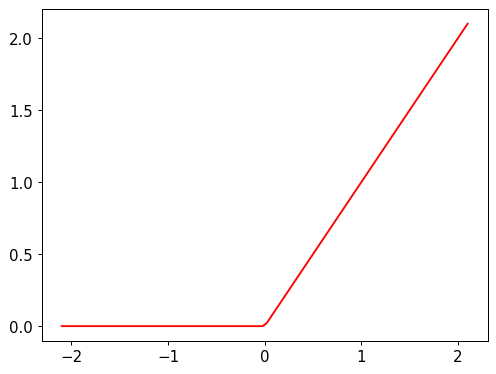

In [112]:
import torch.nn.functional as F

plot_function(F.relu)

In [114]:
simple_net = nn.Sequential(
    nn.Linear(28*28, 30),
    nn.ReLU(),
    nn.Linear(30, 1)
)

In [115]:
learn = Learner(dls, simple_net, opt_func=SGD,
                loss_func=mnist_loss, metrics=batch_accuracy)

In [116]:
learn.fit(40, 0.1)

epoch     train_loss  valid_loss  batch_accuracy  time    
0         0.320869    0.414213    0.504907        00:00                                   
1         0.148934    0.231269    0.798822        00:00                                   
2         0.081772    0.116471    0.914622        00:00                                   
3         0.053339    0.078551    0.941119        00:00                                   
4         0.040247    0.061231    0.954858        00:00                                   
5         0.033615    0.051519    0.963199        00:00                                   
6         0.029837    0.045397    0.966143        00:00                                   
7         0.027397    0.041219    0.967615        00:00                                   
8         0.025646    0.038173    0.969087        00:00                                   
9         0.024293    0.035849    0.969578        00:00                                    
10        0.023198    0.034006

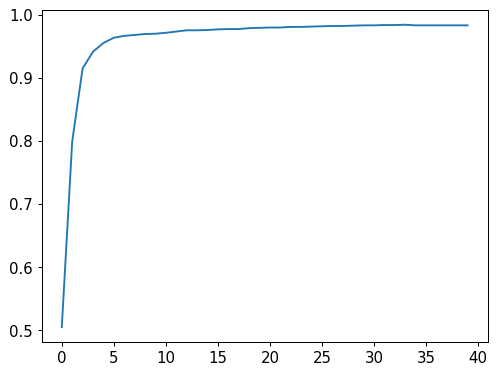

In [120]:
from fastcore.all import L

plt.plot(L(learn.recorder.values).itemgot(2));

In [124]:
learn.recorder.values[-1]

(#3) [0.014198634773492813,0.02050146274268627,0.982826292514801]

### Going Deeper

In [130]:
from fastai.vision.all import ImageDataLoaders, vision_learner, resnet18, accuracy

dls = ImageDataLoaders.from_folder(path)
learn = vision_learner(dls, resnet18, pretrained=False,
                       loss_func=F.cross_entropy, metrics=accuracy)
learn.fit_one_cycle(1, 0.1)

epoch     train_loss  valid_loss  accuracy  time    
0         0.093238    0.011708    0.997547  00:07                                          
